# Create supersites_geom.geojson geojson file with the caucus supersite borders

#### latest run of notebook: 2/9/2024 10am- 
NOTE: need to update precinct to Supersite geojson every time a Supersite/precinct list is modified 
    - e.g. move precincts 814 and 823 from Frasier to Manhatten

## Main Steps
1. create supersites DataFrame from Judi's supersite precinct file
    - INPUT: data/Draft Recap Supersites, Precincts & Chairs 2-9.xlsx (update: 2/9/2024)
    - supersites- DataFrame read from Judi's supersite file
    - OUTPUT: none
2. create pctgeo (precinct GeoDataFrame)
    - INPUT: read precinct geometry from current pct_area_boulder.geojson file
    - add supersite name column using supersites dataframe
    - OUTPUT: data/pct_supersite.geojson (save pctgeo with supersite column) 
    - OUTPUT: data/pct_supersite.xlsx 
3. create ssgeo (supersite border geometry) and save geojson file
    - INPUT: pctgeo GeoDataFrame
    - create ssgeo border_geom
        - from pctgeo by using dissolve('supersite')
    - OUTPUT: data/supersites_region_geom.geojson (save ssgeo)
4. add supersite location information and save file
    - from supersite_venues_all_years.xlsx
        - address
        - website
        - google map link
        - location geometry
    - OUTPUT: supersite_venues.xlsx worksheet=2024
    - OUTPUT: supersite_venues_2024.geojson
5. Create spreadsheet for candidates with Supersites grouped by SD, HD, Area
    - OUTPUT: data/supersite_area_HD_SD_DRAFT_2024_02_09xlsx



### Notebook History Summary
- full history see git commits
- Started: January 7, 2024
- Update: January 8, 2024 - large revision - add ssname column to supersites
- Update: January 9, 2024 - version 0.1.0 add ssgeom to supersitesgeo
- Update: January 11, 2024 - version 0.2.0 add pctlist column to supersites dataframe
- Update: January 12, 2024 - version 0.3.0 start supersite boundary geometry
- Update: January 13, 2024 - version 0.3.1 finish supersite boundary geometry
- Update: January 19, 2024 - version 0.4.0 add supersite locations
- Update: January 21, 2024 - version 0.4.0 update supersite precincts
- Update: Feb 06, 2024 - version 0.5.0 
    - add section 5 - write supersite_area_HD_SD_DRAFT_2024.xlsx
    - update Judi's recap to "proofing 2-2"
- Update: Feb 9, 2024
    - update Judi's recap to "final  2-9"
    - update Judi's spreadsheet to "data/2024_Supersite_list w Chairs & Cochairs-copy.xlsx"


##     ISSUES

#### FIXED Precinct format mismatch
- pct_area_boulder.geojson lists zero-filled precincts, e.g. 002, 003, 004
- Draft Supersites-judi-20240106.xlsx lists single-digit precincts, e.g. 2, 3, 4
    - notebook creates rows for both, 002 and 2, 003 and 3, 004 and 4
    - not critical failure but should be fixed. 
- WORKAROUND: drop extra rows 2, 3, 4
- FIXED: zfill precincts when reading in Judi's file


In [4]:
import pandas as pd
import geopandas as gpd

import supersites as ss
# import fiona
# import numpy as np

## 1. Create supersites - dataframe of supersites with list of precincts in a column  
- start with Judi's spreadsheet
- create pctlist from "Pct #'s" column
    - use pctstr_to_list(ss) function to create series of lists
    - add pctlist series as column on supersites

In [5]:

sstest = pd.read_excel(supersite_input, sheet_name=sheetname, skiprows=3)
sstest.info()
sstest.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CONFIRMED               21 non-null     object 
 1   APPROVED                12 non-null     object 
 2   CONTRACT FINAL          7 non-null      object 
 3   Supersite               21 non-null     object 
 4   AC Areas                21 non-null     object 
 5   Region                  21 non-null     object 
 6   SD                      21 non-null     object 
 7   HD                      21 non-null     object 
 8   # of Reg Dems           21 non-null     int64  
 9   Forecast of  Attendees  21 non-null     float64
 10  # of Pct's              21 non-null     int64  
 11  Pct #'s                 21 non-null     object 
 12  PCT #'s                 21 non-null     int64  
 13  PCT #'s.1               17 non-null     float64
 14  PCT #'s.2               17 non-null     floa

Index(['CONFIRMED', 'APPROVED', 'CONTRACT FINAL', 'Supersite', 'AC Areas',
       'Region', 'SD', 'HD', '# of Reg Dems', 'Forecast of  Attendees',
       '# of Pct's', 'Pct #'s', 'PCT #'s', 'PCT #'s.1', 'PCT #'s.2',
       'PCT #'s.3', 'PCT #'s.4', 'PCT #'s.5', 'PCT #'s.6', 'PCT #'s.7',
       'PCT #'s.8', 'PCT #'s.9', 'PCT #'s.10', 'PCT #'s.11', 'PCT #'s.12',
       'PCT #'s.13', 'PCT #'s.14', 'PCT #'s.15', 'PCT #'s.16', 'PCT #'s.17',
       'PCT #'s.18', 'PCT #'s.19', 'PCT #'s.20', 'PCT #'s.21', 'PCT #'s.22',
       'PCT #'s.23', 'PCT #'s.24', '# of Chairs', 'Chair 1', 'Chair Name',
       'Phone', 'Email', 'Chair 2', 'Chair2 Name', 'Phone.1', 'Email.1',
       'Chair 3', 'Chair3 Name', 'Phone.2', 'Email.2', 'Chair 4',
       'chair 4 Name', 'Phone.3', 'eMail', 'Chair 1.1', 'Chair 2.1',
       'Chair 3.1', 'Chair 4.1', 'Unnamed: 58', 'Sort'],
      dtype='object')

In [6]:
# check supersites
# - total_precincts matches length of pctlist for each supersites
# - 20 unique supersites in dataframe
# - all columns are 20 non-null


# # supersite_input = 'data/Draft Recap Supersites, Precincts & Chairs .xlsx' # 1/13/2024
# supersite_input = 'data/Draft Recap Supersites, Precincts & Chairs-1-28 .xlsx' # 1/22/2024
# supersite_input = 'data/Draft Recap Supersites, Precincts & Chairs 1-29.xlsx' # 1/31/2024
# sheetname ='Draft 1-29'
# supersite_input = 'data/Draft Recap Supersites, Precincts & Chairs 2-6.xlsx' # 1/31/2024
# supersite_input = 'data/Draft Recap Supersites, Precincts & Chairs 2-9.xlsx' # 2/9/2024
# sheetname ='Final 2-9'
supersite_input = 'data/2024_Supersite_list w Chairs & Cochairs-copy.xlsx' # 2/17/2024
sheetname ='Recap SS,Precincts,Chairs'

supersites = ss.read_supersite_pct(supersite_input, sheetname)
supersites.info()
supersites

KeyError: 'attendee_forecast'

In [38]:
# test supersites dataframe for expected supersites
supersites['total_precincts'].sum()
# supersites.describe()
# supersites.iloc[0,4]

193

## 2 create pctgeo (precinct GeoDataFrame)
- read precinct geometry from current pct_area_boulder.geojson file
- add supersite name column using supersites dataframe
- save as pct_supersite.geojson

In [4]:
# 2. Create pctgeo, GeoDataframe from file with individual precinct boundaries
# data/pct_area_boulder.geojson
pctgeo = gpd.read_file('data/pct_area_boulder.geojson', driver='GEOJSON')

# set pctgeo index to Pct
pctgeo = pctgeo.set_index('Pct', drop=False)

pctgeo.info()
pctgeo.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 193 entries, 002 to 916
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pct        193 non-null    object  
 1   Precinct   193 non-null    object  
 2   AreaShort  193 non-null    object  
 3   CD         193 non-null    object  
 4   SD         193 non-null    object  
 5   HD         193 non-null    object  
 6   geometry   193 non-null    geometry
dtypes: geometry(1), object(6)
memory usage: 12.1+ KB


,Pct,Precinct,AreaShort,CD,SD,HD,geometry
Pct,,,,,,,
002,002,2151907002,LM-04,2,15,19,"POLYGON ((-105.05519 40.19115, -105.05518 40.1..."
003,003,2184907003,SU-01,2,18,49,"POLYGON ((-105.16920 39.92870, -105.17207 39.9..."
004,004,2151207004,BO-01,2,15,12,"POLYGON ((-105.18469 39.96263, -105.18459 39.9..."
100,100,2181207100,SU-01,2,18,12,"POLYGON ((-105.15439 39.92921, -105.15842 39.9..."
101,101,2181207101,SU-01,2,18,12,"POLYGON ((-105.14702 39.92887, -105.14736 39.9..."


In [5]:
# test pctgeo for expected results
pctgeo[['Pct', 'Precinct', 'AreaShort', 'CD', 'SD', 'HD']].nunique()

Pct          193
Precinct     193
AreaShort     27
CD             1
SD             3
HD             5
dtype: int64

<Axes: >

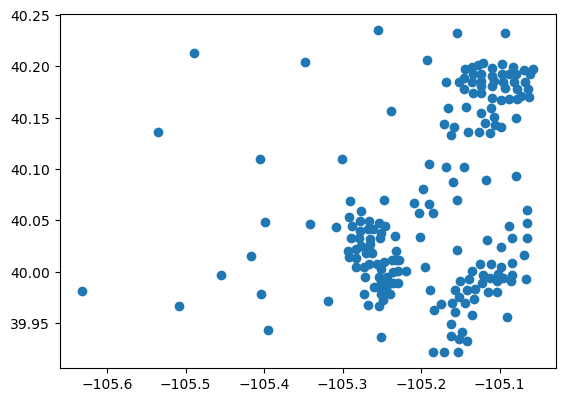

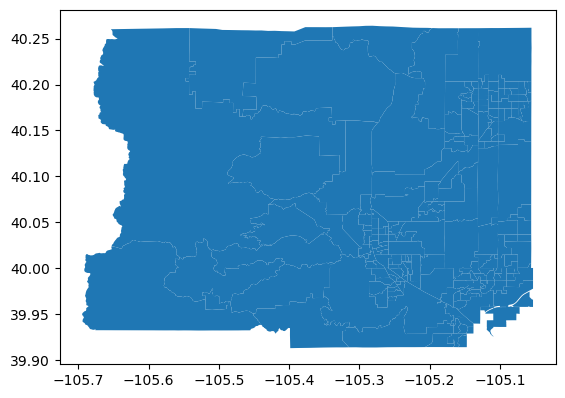

In [6]:
# test pctgeo geometry for valid geometry
pctgeo.representative_point().plot()
pctgeo.plot()

In [7]:
# FUNCTION: Add supersite name column to pctgeo

def add_ss_to_pctgeo(ssdf):

    for ss in ssdf.index:

        # get pctlist in first supersite
        pctlist = ssdf['pctlist'][ss]
        # print(pctlist, '\n')  # list of pcts in supersite

        # get supersite name
        ssname = ssdf.loc[ss,'supersite'] 

        # loop through each pct in pctlist

        for p in pctlist:
            
            # print(p, ssname,'\n')

            # add supersite name to pctgeo
            pctgeo.loc[p, 'supersite'] = ssname
            # print(pctgeo.loc[p, :], '\n')  #  dataframe row
    return



In [8]:
# add supersite column to pctgeo and populate it
pctgeo['supersite'] = ''
add_ss_to_pctgeo(supersites)

pctgeo.info() # check all columns have 193 non-null values
# pctgeo.tail(20)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 193 entries, 002 to 916
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pct        193 non-null    object  
 1   Precinct   193 non-null    object  
 2   AreaShort  193 non-null    object  
 3   CD         193 non-null    object  
 4   SD         193 non-null    object  
 5   HD         193 non-null    object  
 6   geometry   193 non-null    geometry
 7   supersite  193 non-null    object  
dtypes: geometry(1), object(7)
memory usage: 17.6+ KB


In [9]:
# ### Check precinct data in  geodataframe
# - Number of precincts = 193
# - Number of Areas = 27
# - Check precincts in each Area

pctgeo['Pct'].nunique() # 193
pctgeo.AreaShort.nunique() # 27
# pctgeo.value_counts('AreaShort').sort_index()

27

In [10]:
# check # of supersites - expect 20
# pctgeo['supersite'].nunique()

# check precincts per supersite
pctgeo['supersite'].value_counts()

# test pctgeo for expected results
pctgeo[['Pct', 'Precinct', 'AreaShort', 'CD', 'SD', 'HD', 'supersite']].nunique()

Pct          193
Precinct     193
AreaShort     27
CD             1
SD             3
HD             5
supersite     21
dtype: int64

In [11]:
# save pctgeo with supersite column to file 
pctgeo.to_file('data/pct_supersite.geojson', driver='GeoJSON', index=False)

pctgeo.to_excel('data/pct_supersite.xlsx', index=False)

In [12]:
# Add precinct demographic data columns to pctgeo

pctdemo = pd.read_excel('data/pct_demographics_20240106.xlsx', skiprows=0)

pctdemo['pct'] = pctdemo['PCT'].astype(str).str.zfill(3)
pctdemo = pctdemo[['pct','Party', 'General20', 'General22', 'Caucus20',
       'Caucus22']]
pctdemo.info()
pctdemo.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pct        193 non-null    object
 1   Party      193 non-null    int64 
 2   General20  193 non-null    int64 
 3   General22  193 non-null    int64 
 4   Caucus20   193 non-null    int64 
 5   Caucus22   193 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 9.2+ KB


,pct,Party,General20,General22,Caucus20,Caucus22
0,002,2,2,2,0,0
1,003,0,0,0,0,0
2,004,0,0,0,0,0
3,100,525,455,413,6,5
4,101,490,428,395,10,3


In [13]:
# pctdemo.columns

In [14]:
pctgeo.head()

pctdf = pctgeo.reset_index(drop=True)
pctdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pct        193 non-null    object  
 1   Precinct   193 non-null    object  
 2   AreaShort  193 non-null    object  
 3   CD         193 non-null    object  
 4   SD         193 non-null    object  
 5   HD         193 non-null    object  
 6   geometry   193 non-null    geometry
 7   supersite  193 non-null    object  
dtypes: geometry(1), object(7)
memory usage: 12.2+ KB


In [15]:
pctdemogeo = pd.merge(pctdf, pctdemo, left_on='Pct', right_on='pct')
# pctdemogeo = pctgeo.join(pctdemo, on='pct', how='left')

pctdemogeo.drop(columns=['pct'])
pctdemogeo.info()
pctdemogeo.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pct        193 non-null    object  
 1   Precinct   193 non-null    object  
 2   AreaShort  193 non-null    object  
 3   CD         193 non-null    object  
 4   SD         193 non-null    object  
 5   HD         193 non-null    object  
 6   geometry   193 non-null    geometry
 7   supersite  193 non-null    object  
 8   pct        193 non-null    object  
 9   Party      193 non-null    int64   
 10  General20  193 non-null    int64   
 11  General22  193 non-null    int64   
 12  Caucus20   193 non-null    int64   
 13  Caucus22   193 non-null    int64   
dtypes: geometry(1), int64(5), object(8)
memory usage: 21.2+ KB


,Pct,Precinct,AreaShort,CD,SD,HD,geometry,supersite,pct,Party,General20,General22,Caucus20,Caucus22
0,002,2151907002,LM-04,2,15,19,"POLYGON ((-105.05519 40.19115, -105.05518 40.1...",Timberline K-8,002,2,2,2,0,0
1,003,2184907003,SU-01,2,18,49,"POLYGON ((-105.16920 39.92870, -105.17207 39.9...",Eldorado K8,003,0,0,0,0,0
2,004,2151207004,BO-01,2,15,12,"POLYGON ((-105.18469 39.96263, -105.18459 39.9...",Platt MS,004,0,0,0,0,0
3,100,2181207100,SU-01,2,18,12,"POLYGON ((-105.15439 39.92921, -105.15842 39.9...",Eldorado K8,100,525,455,413,6,5
4,101,2181207101,SU-01,2,18,12,"POLYGON ((-105.14702 39.92887, -105.14736 39.9...",Eldorado K8,101,490,428,395,10,3


In [16]:
# create pct_supersite_demo.xlsx


pctdemogeo.to_excel('data/pct_supersite_demo.xlsx', index=False)

### 3 Create Supersite GeoDataFrame, ssgeo, and add geometry column 

- create ssgeo by dissolving pctgeo('supersite')
- save ssgeo to supersites_region_geom.geojson

,supersite,geometry
0,Allenspark Fire Station,"POLYGON ((-105.33835 40.25280, -105.33828 40.2..."
1,Altona MS,"POLYGON ((-105.14599 40.12877, -105.14621 40.1..."
2,Burlington Elementary,"POLYGON ((-105.12564 40.13071, -105.12952 40.1..."
3,Casey MS,"POLYGON ((-105.27022 40.01460, -105.27166 40.0..."
4,Centaurus HS,"MULTIPOLYGON (((-105.11339 39.97608, -105.1132..."
5,Centennial MS,"POLYGON ((-105.27269 40.03630, -105.27269 40.0..."
6,Eldorado K8,"POLYGON ((-105.16840 39.92870, -105.16741 39.9..."
7,Fairview HS,"MULTIPOLYGON (((-105.23320 39.98584, -105.2330..."
8,Gold Hill School,"POLYGON ((-105.34886 40.03821, -105.34871 40.0..."
9,Horizon K-8,"POLYGON ((-105.23167 39.99123, -105.23169 39.9..."


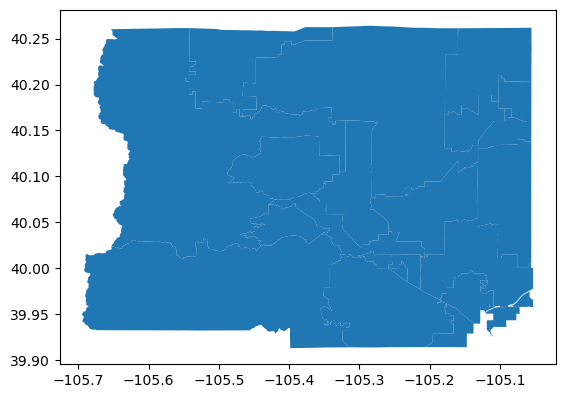

In [17]:
# Create ssgeo: Supersite GeoDataFrame with supersite boundaries
#   pctgeo.dissolve('supersite') 
#      group precincts by supersite 
#      combine group precinct geometry into supersite geometry

ssgeo = pctgeo.dissolve('supersite')
ssgeo = ssgeo.reset_index()
ssgeo = ssgeo[['supersite','geometry']]
ssgeo['supersite'] = ssgeo['supersite'].str.strip()

ssgeo.to_file('data/supersites_region_geom.geojson', driver='GeoJSON')

ssgeo.plot()
ssgeo

### test supersite_region_geom.geojson

In [18]:
supersite_test = gpd.read_file('data/supersites_region_geom.geojson', driver='GeoJSON')
supersite_test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   supersite  21 non-null     object  
 1   geometry   21 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 468.0+ bytes


<Axes: >

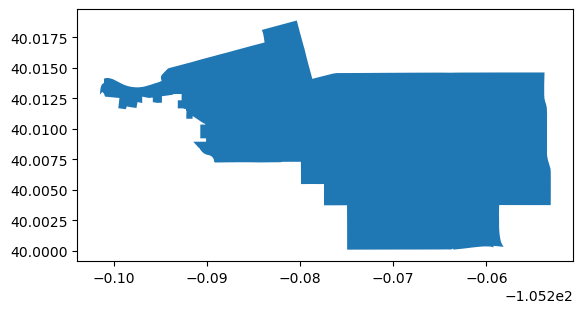

In [19]:
# supersite_test[supersite_test['supersite'] == 'Boulder HS'].plot()
# supersite_test[supersite_test['supersite'] == 'Allenspark Fire Station'].plot()
supersite_test[supersite_test['supersite'] == 'New Vista'].plot()

## 4 ADD LOCATION COLUMN TO 2024 SUPERSITES
- ssgeo GeoDataFrame
    - add location_geom column from supersite_venues_all_years.xlsx
    - copy geometry column to border
    - set_geometry('border') to border

In [20]:
ssgeo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   supersite  21 non-null     object  
 1   geometry   21 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 468.0+ bytes


In [21]:
ssgeo

,supersite,geometry
0,Allenspark Fire Station,"POLYGON ((-105.33835 40.25280, -105.33828 40.2..."
1,Altona MS,"POLYGON ((-105.14599 40.12877, -105.14621 40.1..."
2,Burlington Elementary,"POLYGON ((-105.12564 40.13071, -105.12952 40.1..."
3,Casey MS,"POLYGON ((-105.27022 40.01460, -105.27166 40.0..."
4,Centaurus HS,"MULTIPOLYGON (((-105.11339 39.97608, -105.1132..."
5,Centennial MS,"POLYGON ((-105.27269 40.03630, -105.27269 40.0..."
6,Eldorado K8,"POLYGON ((-105.16840 39.92870, -105.16741 39.9..."
7,Fairview HS,"MULTIPOLYGON (((-105.23320 39.98584, -105.2330..."
8,Gold Hill School,"POLYGON ((-105.34886 40.03821, -105.34871 40.0..."
9,Horizon K-8,"POLYGON ((-105.23167 39.99123, -105.23169 39.9..."


In [22]:
# read in supersite_venues.xlsx
venues = pd.read_excel('data/venues_all_years_fixed.xlsx')

venues.info()
venues

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.2  37 non-null     int64  
 1   Unnamed: 0.1  37 non-null     int64  
 2   Unnamed: 0    37 non-null     int64  
 3   venue_id      34 non-null     float64
 4   venue         34 non-null     object 
 5   venue_code    34 non-null     object 
 6   address       34 non-null     object 
 7   org           30 non-null     object 
 8   website       32 non-null     object 
 9   gmap_link     33 non-null     object 
 10  gmap_name     35 non-null     object 
 11  lat           34 non-null     float64
 12  lon           34 non-null     float64
 13  geometry      37 non-null     object 
dtypes: float64(3), int64(3), object(8)
memory usage: 4.2+ KB


,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,venue_id,venue,venue_code,address,org,website,gmap_link,gmap_name,lat,lon,geometry
0,0,0,0,0.0,Allenspark Fire Station,ALLP_FS,"14861 CO-7, Allenspark, CO 80510",NaN,http://www.allensparkfire.com/,https://maps.app.goo.gl/HYN1GYNb9yE4w4RL7,Allenspark Fire Protection,40.197128,-105.527914,POINT (-105.5279141785934 40.19712777610975)
1,1,1,1,1.0,Altona MS,ALTO_MS,"4600 Clover Basin Dr, Longmont, CO 80503",SVVSD,https://ams.svvsd.org/,https://maps.app.goo.gl/ew5ypnry93DZwFNj8,Altona Middle School,40.144483,-105.162618,POINT (-105.1626179175455 40.14448266991539)
2,2,2,2,2.0,Angevine MS,ANGV_MS,"1150 W South Boulder Rd, Lafayette, CO 80026",BVSD,http://anm.bvsd.org/,https://maps.app.goo.gl/QtidHUByDwtU8Z599,Angevine Middle School,39.989559,-105.103357,POINT (-105.1033574278846 39.98955883968855)
3,3,3,3,3.0,Boulder HS,BLDR_HS,"1604 Arapahoe Ave, Boulder, CO 80302",BVSD,http://boh.bvsd.org/,https://maps.app.goo.gl/dKMDjeKUL4kjNDMp6,Boulder High School,40.014116,-105.272871,POINT (-105.2728711769165 40.01411590640171)
4,4,4,4,4.0,Burlington Elementary,BURL_ES,"1051 S Pratt Pkwy, Longmont, CO 80501",SVVSD,http://bes.svvsd.org/,https://maps.app.goo.gl/QefhqxMskS5oyZY87,Burlington Elementary School,40.146654,-105.108633,POINT (-105.108633248163 40.1466539913149)
5,5,5,5,5.0,Casey MS,CASE_MS,"1301 High St, Boulder, CO 80304",BVSD,http://cam.bvsd.org/,https://maps.app.goo.gl/kqj3JEma8TPCRKWU9,Casey Middle School,40.022871,-105.279158,POINT (-105.2791579470394 40.0228711759357)
6,6,6,6,6.0,Centaurus HS,CTAU_HS,"10300 W South Boulder Rd, Lafayette, CO 80026",BVSD,http://ceh.bvsd.org/,https://maps.app.goo.gl/qmDEC4W3XTN7acfs9,Centaurus High School,39.986360,-105.112528,POINT (-105.1125276640655 39.98635981263706)
7,7,7,7,7.0,Centennial MS,CNTL_MS,"2205 Norwood Ave, Boulder, CO 80304",BVSD,http://cem.bvsd.org/,https://maps.app.goo.gl/tKhhHtoniAvTfpPH9,Centennial Middle School,40.045068,-105.267147,POINT (-105.2671472290834 40.04506796264024)
8,8,8,8,8.0,Eldorado K8,ELDO_K8,"3351 S Indiana St, Superior, CO 80027",BVSD,http://el8.bvsd.org/,https://maps.app.goo.gl/s2gJjfVYasWGLpMz7,Eldorado K-8 School,39.921698,-105.161197,POINT (-105.161197194222 39.921698179021)
9,9,9,9,9.0,Eldorado Sp. Fire House,ELSP_FS,"4390 Eldorado Springs Dr, Boulder, CO 80303",NaN,NaN,https://maps.app.goo.gl/TBWeoHAtGKUfwDy79,Rocky Mountain Fire District Station 6,39.942662,-105.249310,POINT (-105.2493101229037 39.94266172014046)


In [23]:
venues['venue'] = venues['venue'].str.strip()

In [24]:
# create GeoDataFrame with location geometry from lon and lat columns
vengdf = gpd.GeoDataFrame(venues, geometry=gpd.points_from_xy(venues['lon'], venues['lat']), crs='EPSG:4326' )

vengdf.info()
# vengdf.plot()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Unnamed: 0.2  37 non-null     int64   
 1   Unnamed: 0.1  37 non-null     int64   
 2   Unnamed: 0    37 non-null     int64   
 3   venue_id      34 non-null     float64 
 4   venue         34 non-null     object  
 5   venue_code    34 non-null     object  
 6   address       34 non-null     object  
 7   org           30 non-null     object  
 8   website       32 non-null     object  
 9   gmap_link     33 non-null     object  
 10  gmap_name     35 non-null     object  
 11  lat           34 non-null     float64 
 12  lon           34 non-null     float64 
 13  geometry      37 non-null     geometry
dtypes: float64(3), geometry(1), int64(3), object(7)
memory usage: 4.2+ KB


In [25]:
vengdf.to_excel('data/venues_all_years_fixed.xlsx')

In [26]:
# merge in location information to venues2024
ss2024 = pd.merge(ssgeo, vengdf, left_on='supersite', right_on='venue', how='left')
ss2024 = ss2024.rename(columns={'geometry_x':'border_geom', 'geometry_y': 'location_geom'})
ss2024 = ss2024.set_geometry('location_geom')
# ss2024 = ss2024.drop(columns=['geometry-invalid'])
# ss2024 = ss2024.set_geometry('border_geom')

ss2024 = ss2024.set_crs('EPSG:4326')

ss2024.info()
ss2024

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   supersite      21 non-null     object  
 1   border_geom    21 non-null     geometry
 2   Unnamed: 0.2   18 non-null     float64 
 3   Unnamed: 0.1   18 non-null     float64 
 4   Unnamed: 0     18 non-null     float64 
 5   venue_id       18 non-null     float64 
 6   venue          18 non-null     object  
 7   venue_code     18 non-null     object  
 8   address        18 non-null     object  
 9   org            16 non-null     object  
 10  website        17 non-null     object  
 11  gmap_link      17 non-null     object  
 12  gmap_name      18 non-null     object  
 13  lat            18 non-null     float64 
 14  lon            18 non-null     float64 
 15  location_geom  18 non-null     geometry
dtypes: float64(6), geometry(2), object(8)
memory usage: 2.8+ KB


,supersite,border_geom,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,venue_id,venue,venue_code,address,org,website,gmap_link,gmap_name,lat,lon,location_geom
0,Allenspark Fire Station,"POLYGON ((-105.33835 40.25280, -105.33828 40.2...",0.0,0.0,0.0,0.0,Allenspark Fire Station,ALLP_FS,"14861 CO-7, Allenspark, CO 80510",NaN,http://www.allensparkfire.com/,https://maps.app.goo.gl/HYN1GYNb9yE4w4RL7,Allenspark Fire Protection,40.197128,-105.527914,POINT (-105.52791 40.19713)
1,Altona MS,"POLYGON ((-105.14599 40.12877, -105.14621 40.1...",1.0,1.0,1.0,1.0,Altona MS,ALTO_MS,"4600 Clover Basin Dr, Longmont, CO 80503",SVVSD,https://ams.svvsd.org/,https://maps.app.goo.gl/ew5ypnry93DZwFNj8,Altona Middle School,40.144483,-105.162618,POINT (-105.16262 40.14448)
2,Burlington Elementary,"POLYGON ((-105.12564 40.13071, -105.12952 40.1...",4.0,4.0,4.0,4.0,Burlington Elementary,BURL_ES,"1051 S Pratt Pkwy, Longmont, CO 80501",SVVSD,http://bes.svvsd.org/,https://maps.app.goo.gl/QefhqxMskS5oyZY87,Burlington Elementary School,40.146654,-105.108633,POINT (-105.10863 40.14665)
3,Casey MS,"POLYGON ((-105.27022 40.01460, -105.27166 40.0...",5.0,5.0,5.0,5.0,Casey MS,CASE_MS,"1301 High St, Boulder, CO 80304",BVSD,http://cam.bvsd.org/,https://maps.app.goo.gl/kqj3JEma8TPCRKWU9,Casey Middle School,40.022871,-105.279158,POINT (-105.27916 40.02287)
4,Centaurus HS,"MULTIPOLYGON (((-105.11339 39.97608, -105.1132...",6.0,6.0,6.0,6.0,Centaurus HS,CTAU_HS,"10300 W South Boulder Rd, Lafayette, CO 80026",BVSD,http://ceh.bvsd.org/,https://maps.app.goo.gl/qmDEC4W3XTN7acfs9,Centaurus High School,39.986360,-105.112528,POINT (-105.11253 39.98636)
5,Centennial MS,"POLYGON ((-105.27269 40.03630, -105.27269 40.0...",7.0,7.0,7.0,7.0,Centennial MS,CNTL_MS,"2205 Norwood Ave, Boulder, CO 80304",BVSD,http://cem.bvsd.org/,https://maps.app.goo.gl/tKhhHtoniAvTfpPH9,Centennial Middle School,40.045068,-105.267147,POINT (-105.26715 40.04507)
6,Eldorado K8,"POLYGON ((-105.16840 39.92870, -105.16741 39.9...",8.0,8.0,8.0,8.0,Eldorado K8,ELDO_K8,"3351 S Indiana St, Superior, CO 80027",BVSD,http://el8.bvsd.org/,https://maps.app.goo.gl/s2gJjfVYasWGLpMz7,Eldorado K-8 School,39.921698,-105.161197,POINT (-105.16120 39.92170)
7,Fairview HS,"MULTIPOLYGON (((-105.23320 39.98584, -105.2330...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
8,Gold Hill School,"POLYGON ((-105.34886 40.03821, -105.34871 40.0...",12.0,12.0,12.0,12.0,Gold Hill School,GOLD_ES,"890 Main St, Boulder, CO 80302",BVSD,http://ghe.bvsd.org/,https://maps.app.goo.gl/PZV28vuUvb8p7LJs6,Gold Hill Elementary School,40.063366,-105.412473,POINT (-105.41247 40.06337)
9,Horizon K-8,"POLYGON ((-105.23167 39.99123, -105.23169 39.9...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


<Axes: >

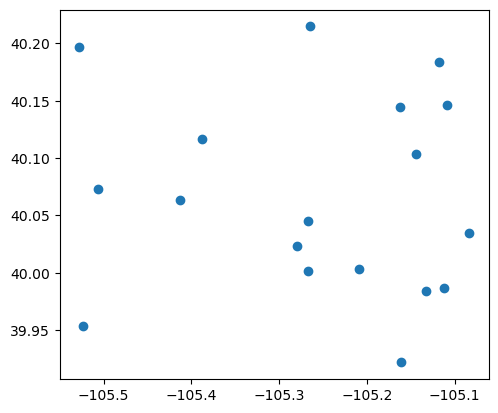

In [27]:
ss2024.plot()

<Axes: >

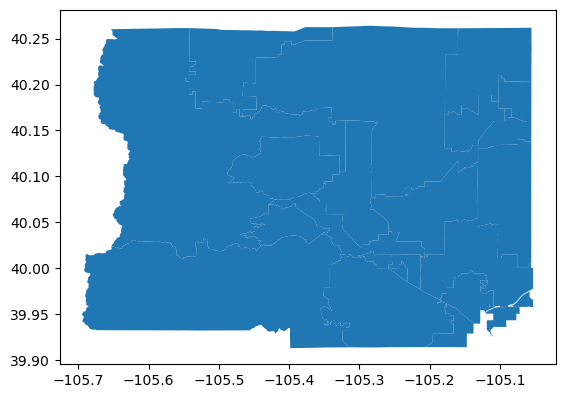

In [28]:
ss2024.set_geometry('border_geom').plot()

In [29]:

ss2024.to_excel('data/supersites_geom_2024.xlsx')

In [30]:
# save supersite locations in geojson file

ss2024.set_geometry('location_geom')
ss2024.drop(columns=['border_geom']).to_file('data/supersites_location_geom_2024.geojson', driver='GeoJSON')

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   supersite     21 non-null     object  
 1   Unnamed: 0.2  18 non-null     float64 
 2   Unnamed: 0.1  18 non-null     float64 
 3   Unnamed: 0    18 non-null     float64 
 4   venue_id      18 non-null     float64 
 5   venue         18 non-null     object  
 6   venue_code    18 non-null     object  
 7   address       18 non-null     object  
 8   org           16 non-null     object  
 9   website       17 non-null     object  
 10  gmap_link     17 non-null     object  
 11  gmap_name     18 non-null     object  
 12  lat           18 non-null     float64 
 13  lon           18 non-null     float64 
 14  geometry      18 non-null     geometry
dtypes: float64(6), geometry(1), object(8)
memory usage: 2.6+ KB


<Axes: >

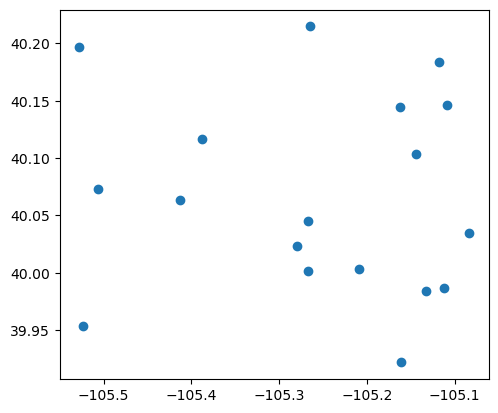

In [31]:
ss2024gdf = gpd.read_file('data/supersites_location_geom_2024.geojson', driver='GeoJSON')

ss2024gdf.info()
ss2024gdf.plot()


## 5 Create spreadsheet with Supersite data for candidates and supersite chairs
- For candidates
    - Supersite and precincts grouped by Area, SD, HD

In [32]:
# create pctss dataframe from pctgeo

pctgeo.columns
pctss = pctgeo[['Pct', 'AreaShort', 'SD', 'HD', 'supersite']]

pctss.info()
pctss

<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, 002 to 916
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Pct        193 non-null    object
 1   AreaShort  193 non-null    object
 2   SD         193 non-null    object
 3   HD         193 non-null    object
 4   supersite  193 non-null    object
dtypes: object(5)
memory usage: 13.1+ KB


,Pct,AreaShort,SD,HD,supersite
Pct,,,,,
002,002,LM-04,15,19,Timberline K-8
003,003,SU-01,18,49,Eldorado K8
004,004,BO-01,15,12,Platt MS
100,100,SU-01,18,12,Eldorado K8
101,101,SU-01,18,12,Eldorado K8
...,...,...,...,...,...
912,912,MT-02,15,49,Centennial MS
913,913,MT-02,15,49,Jamestown School
914,914,MT-03,15,49,Allenspark Fire Station


In [33]:
# Create ss_areas dataframe that list Areas, CD, SD, HD for each supersite

def collist(s):
    return s.unique().tolist()

ss_areas = pctss.groupby('supersite').agg(
    areas=('AreaShort', collist),
    SDs=('SD', collist),
    HDs=('HD', collist),
    PCTs=('Pct', collist)
)

# convert lists in areas, SDs, HDs, PCTs to strings

ss_areas['area'] = [','.join(map(str, l)) for l in ss_areas['areas']]
ss_areas['sd'] = [','.join(map(str, l)) for l in ss_areas['SDs']]
ss_areas['hd'] = [','.join(map(str, l)) for l in ss_areas['HDs']]
ss_areas['pct'] = [','.join(map(str, l)) for l in ss_areas['PCTs']]

ss_areas = ss_areas[['area', 'sd', 'hd', 'pct']]

ss_areas.info()
ss_areas


<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, Allenspark Fire Station  to Ward Town Hall
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   area    21 non-null     object
 1   sd      21 non-null     object
 2   hd      21 non-null     object
 3   pct     21 non-null     object
dtypes: object(4)
memory usage: 840.0+ bytes


,area,sd,hd,pct
supersite,,,,
Allenspark Fire Station,MT-03,15,49,914
Altona MS,"LM-02,LM-03",17,11,"605,606,607,608,609,610,611,614,615,616,624,62..."
Burlington Elementary,LM-01,17,11,"600,601,602,603,604,612,613"
Casey MS,"BO-08,BO-07,MT-02","18,15","10,49","810,817,818,820,821,822,823,824,825,826,827,910"
Centaurus HS,"LF-01,LF-02","17,18",12,"300,301,302,303,304,305,306,307,308,309,310,31..."
Centennial MS,"BO-10,BO-09,MT-02","18,15","10,49","803,804,805,806,807,811,812,813,814,815,816,91..."
Eldorado K8,SU-01,18,"49,12","003,100,101,102,103,104,105,106"
Fairview HS,"BO-02,BO-03,BO-01","18,15","10,49","830,843,844,845,846,847,850,851,852,853,854,85..."
Gold Hill School,MT-02,15,49,909


In [34]:
# create dataframe of supersites and precincts in every hd
hd_ss = pctss.groupby('HD').agg(
    supersites=('supersite', collist),
    PCTs=('Pct', collist)
)

# convert hd lists to strings
hd_ss['supersite'] = [','.join(map(str, l)) for l in hd_ss['supersites']]
hd_ss['pct'] = [','.join(map(str, l)) for l in hd_ss['PCTs']]

hd_ss = hd_ss[['supersite', 'pct']]

hd_ss.info()
hd_ss

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 10 to 49
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   supersite  5 non-null      object
 1   pct        5 non-null      object
dtypes: object(2)
memory usage: 120.0+ bytes


,supersite,pct
HD,,
10,"Niwot HS,Centennial MS,Casey MS,New Vista,Fair...","800,801,802,803,806,807,808,809,810,811,812,81..."
11,"Burlington Elementary,Altona MS,Longs Peak MS,...","600,601,602,603,604,605,606,607,608,609,610,61..."
12,"Platt MS,Eldorado K8,Louisville MS,Centaurus H...","004,100,101,102,103,104,105,106,200,201,202,20..."
19,"Timberline K-8,Meadowlark","002,400,401,402,403,404,405,406,407,408,619,62..."
49,"Eldorado K8,Lyons Middle Senior,Longs Peak MS,...","003,701,702,704,705,804,805,814,815,827,828,84..."


In [35]:
# create dataframe of supersites and precincts in every sd
sd_ss = pctss.groupby('SD').agg(
    supersites=('supersite', collist),
    PCTs=('Pct', collist)
)

sd_ss['supersite'] = [','.join(map(str, l)) for l in sd_ss['supersites']]
sd_ss['pct'] = [','.join(map(str, l)) for l in sd_ss['PCTs']]

sd_ss = sd_ss[['supersite', 'pct']]

sd_ss.info()
sd_ss

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 15 to 18
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   supersite  3 non-null      object
 1   pct        3 non-null      object
dtypes: object(2)
memory usage: 72.0+ bytes


,supersite,pct
SD,,
15,"Timberline K-8,Platt MS,Lyons Middle Senior,Lo...","002,004,700,701,702,703,704,705,900,901,902,90..."
17,"Centaurus HS,Meadowlark,Burlington Elementary,...","300,301,302,303,304,305,306,307,308,309,310,31..."
18,"Eldorado K8,Louisville MS,Centaurus HS,Niwot H...","003,100,101,102,103,104,105,106,200,201,202,20..."


In [36]:
# write spreadsheet with Supersite information by Area, HD, SD

with pd.ExcelWriter('data/supersite_area_HD_SD_FINAL_2024_02_09.xlsx') as writer:
    
    ss_areas.to_excel(writer, sheet_name='Areas, SD, HD at Supersite', index=True)
    hd_ss.to_excel(writer, sheet_name="HDs")  
    sd_ss.to_excel(writer, sheet_name="SDs")  